# SELF-SUPERVISED DENOISING: PART ONE
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to write your own blind-spot denoising procedure that is trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required!

## Methodology Recap
We will implement the Noise2Void methodology of blind-spot networks for denoising. This involves performing a pre-processing step which identifies the 'active' pixels and then replaces their original noisy value with that of a neighbouring pixel. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations.

***

In [1]:
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
from tutorial_utils import regular_patching_2D, add_whitegaussian_noise, weights_init, set_seed, make_data_loader, plot_corruption, plot_training_metrics, plot_synth_results



In [2]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='RdBu'
vmin = -0.25
vmax = 0.25

# For reproducibility purposes we set random, numpy and torch seeds
set_seed(42) 

True

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the public data folder: https://exrcsdrive.kaust.edu.sa/exrcsdrive/index.php/s/vjjry6BZ3n3Ewei

with password: `kaust`

If the folder is no longer public, this is likely due to expired rights. Please email: cebirnie[at]kaust.edu.sa to request access. 

In this instance I have downloaded the file and added to a folder in this repository title 'data'.

In [3]:
d = np.load("../data/Hess_PostStackSection.npy")

# Check data dimensions
print(d.shape)

(196, 452)


#### Plot the data to see what it looks like

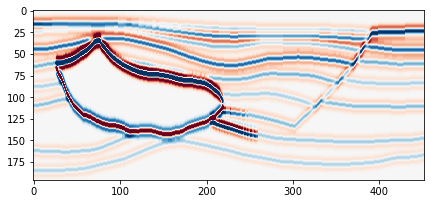

In [4]:
plt.figure(figsize=[7,5])
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

As we can see from above, the data which you loaded in is the noise-free synthetic. This is great for helping us benchmark the results however we are really interested in testing the denoising performance of blind-spot networks there we need to add some noise that we wish to later suppress. 

In [5]:
noisydata, _ = add_whitegaussian_noise(d, sc=0.1)

#### Plot the noisy data to see what it looks like in comparison to the clean

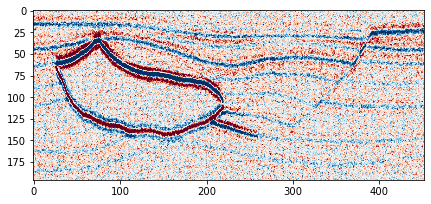

In [6]:
plt.figure(figsize=[7,5])
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [7]:
# Regularly extract patches from the noisy data
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 2870 patches


#### Visualise the training patches

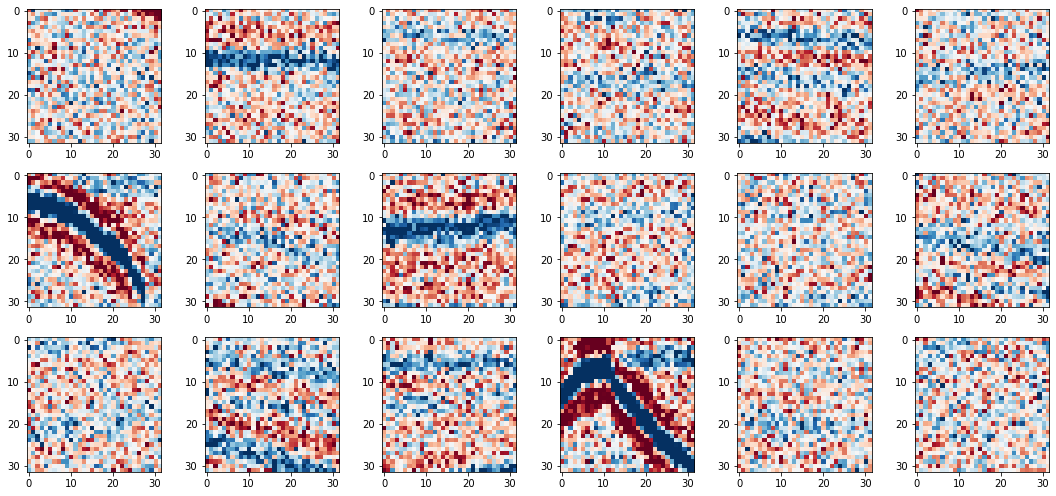

In [8]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:

    - selecting the active pixels 
    - selecting the neighbourhood pixel for each active pixel, which it will take the value of
    - replacing each active pixels' value with its neighbourhood pixels' value
    - creating a active pixel 'mask' which shows the location of the active pixels on the patch
    
The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

#### To do: Create a function that randomly selects and corrupts pixels following N2V methodology

In [9]:
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5,
                       ):
    """ Function to identify multiple active pixels and replace with values from neighbouring pixels
    
    Parameters
    ----------
    patch : numpy 2D array
        Noisy patch of data to be processed
    num_activepixels : int
        Number of active pixels to be selected within the patch
    neighbourhood_radius : int
        Radius over which to select neighbouring pixels for active pixel value replacement
    Returns
    -------
        cp_ptch : numpy 2D array
            Processed patch 
        mask : numpy 2D array
            Mask showing location of active pixels within the patch 
    """

    n_rad = neighbourhood_radius  # descriptive variable name was a little long

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)
    id_aps = (idx_aps, idy_aps)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP TWO: SELECT NEIGHBOURING PIXEL LOCATIONS
    
    # PART 1: Compute Shift
    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # PART 2: Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft    
    # Ensure neighbouring pixels within patch window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    # Get x,y of neighbouring pixels
    id_neigh = (idx_neigh, idy_neigh)
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP THREE: REPLACE ACTIVE PIXEL VALUES BY NEIGHBOURS
    cp_ptch = patch.copy()
    cp_ptch[id_aps] = patch[id_neigh]
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # STEP FOUR: MAKE ACTIVE PIXEL MASK
    mask = np.ones_like(patch)
    mask[id_aps] = 0.

    return cp_ptch, mask


#### TO DO:  CHECK THE CORRUPTION FUNCTION WORKS

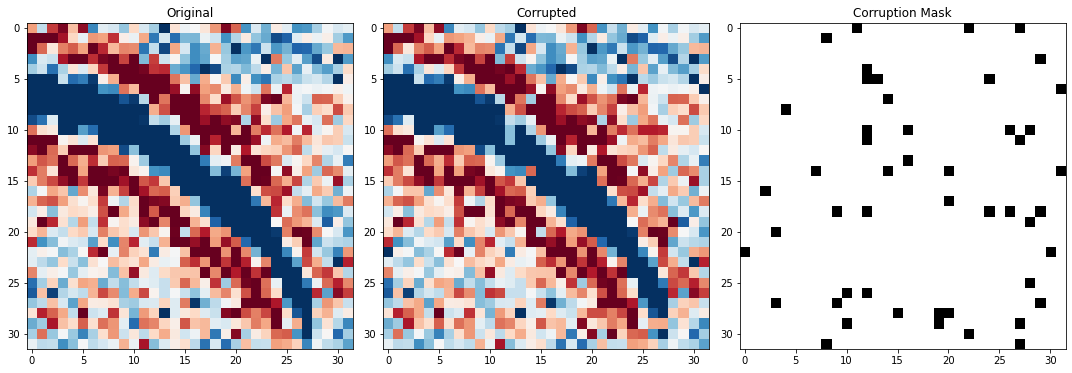

In [10]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[6], 
                                       num_activepixels=50, 
                                       neighbourhood_radius=5, 
                                      )

# Use the pre-made plotting function to visualise the corruption
fig,axs = plot_corruption(noisy_patches[6], crpt_patch, mask)

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)

In the original N2V examples the authors use between 0.5 and 2% for the number of active pixels within a patch.

In Birnie et al., 2021 where they use this methodology for the suppression of white, Gaussian noise, the authors use 0.2%. However, in their example they have substantially more training patches.

Number of active pixels selected: 
 2.00 percent equals 20 pixels


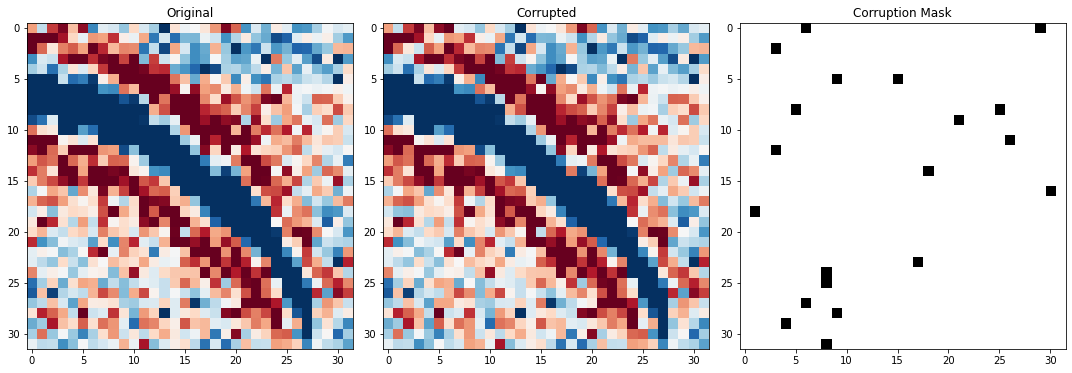

In [11]:
# Choose the percent of active pixels per patch
perc_active = 2

# Compute the total number of pixels within a patch
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
# Compute the number that should be active pixels based on the choosen percentage
num_activepixels = int(np.floor((total_num_pixels/100) * perc_active))
print("Number of active pixels selected: \n %.2f percent equals %i pixels"%(perc_active,num_activepixels))

# Input the values of your choice into your pre-processing function
crpt_patch, mask = multi_active_pixels(noisy_patches[6], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=5, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = plot_corruption(noisy_patches[6], crpt_patch, mask)

***

# Step three - Set up network

In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [12]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


#### Build the network

In [13]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(weights_init) 

/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/Solutions/tutorial_utils.py:267: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/Solutions/tutorial_utils.py:268: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


#### Select the networks training parameters

In [14]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step four - Network Training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [15]:
# Choose the number of epochs
n_epochs = 100  # most recommend 150-200 for random noise suppression 

# Choose number of training and validation samples
n_training = 2048
n_test = 512

# Choose the batch size for the networks training
batch_size = 128

In [16]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

#### TO DO: INCORPORATE LOSS FUNCTION INTO TRAINING PROCEDURE

In [17]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    """ Blind-spot network training function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where training will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Training loss across full dataset (i.e., all batches)
        accuracy : float
            Training RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        
        optimizer.zero_grad()
        
        # Predict the denoised image based on current network weights
        yprob = model(X)

        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        # TO DO: Compute loss function only at masked locations and backpropogate it
        # (Hint: only two lines required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        ls.backward()        
        #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
            
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

#### TO DO: INCORPORATE LOSS FUNCTION INTO VALIDATION PROCEDURE

In [18]:
def n2v_evaluate(model,
                 criterion, 
                 optimizer, 
                 data_loader, 
                 device):
    """ Blind-spot network evaluation function
    
    Parameters
    ----------
    model : torch model
        Neural network
    criterion : torch criterion
        Loss function 
    optimizer : torch optimizer
        Network optimiser
    data_loader : torch dataloader
        Premade data loader with training data batches
    device : torch device
        Device where network computation will occur (e.g., CPU or GPU)
    
    Returns
    -------
        loss : float
            Validation loss across full dataset (i.e., all batches)
        accuracy : float
            Validation RMSE accuracy across full dataset (i.e., all batches) 
    """
    
    model.train()
    accuracy = 0  # initialise accuracy at zero for start of epoch
    loss = 0  # initialise loss at zero for start of epoch

    for dl in tqdm(data_loader):
        
        # Load batch of data from data loader 
        X, y, mask = dl[0].to(device), dl[1].to(device), dl[2].to(device)
        optimizer.zero_grad()
        
        yprob = model(X)

        with torch.no_grad():            
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
            # TO DO: Compute loss function only at masked locations 
            # (Hint: only one line required)
            ls = criterion(yprob * (1 - mask), y * (1 - mask))
            #  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        
        # Retain training metrics
        loss += ls.item()  
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))  
        
    # Divide cumulative training metrics by number of batches for training
    loss /= len(data_loader)  
    accuracy /= len(data_loader)  

    return loss, accuracy

#### TO DO: COMPLETE TRAINING LOOP BY INCORPORATING ABOVE FUNCTIONS

In [19]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=5, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 4/4 [00:00<00:00, 22.46it/s]


Epoch 0, 
    Training Loss 0.0003,     Training Accuracy 0.1286, 
    Test Loss 0.0003,     Test Accuracy 0.1127 


100%|██████████| 4/4 [00:00<00:00, 23.70it/s]


Epoch 1, 
    Training Loss 0.0002,     Training Accuracy 0.1094, 
    Test Loss 0.0002,     Test Accuracy 0.1077 


100%|██████████| 4/4 [00:00<00:00, 22.97it/s]


Epoch 2, 
    Training Loss 0.0002,     Training Accuracy 0.1073, 
    Test Loss 0.0002,     Test Accuracy 0.1074 


100%|██████████| 4/4 [00:00<00:00, 22.97it/s]


Epoch 3, 
    Training Loss 0.0002,     Training Accuracy 0.1077, 
    Test Loss 0.0002,     Test Accuracy 0.1081 


100%|██████████| 4/4 [00:00<00:00, 23.74it/s]


Epoch 4, 
    Training Loss 0.0002,     Training Accuracy 0.1074, 
    Test Loss 0.0002,     Test Accuracy 0.1068 


100%|██████████| 4/4 [00:00<00:00, 22.66it/s]


Epoch 5, 
    Training Loss 0.0002,     Training Accuracy 0.1069, 
    Test Loss 0.0002,     Test Accuracy 0.1074 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 6, 
    Training Loss 0.0002,     Training Accuracy 0.1073, 
    Test Loss 0.0002,     Test Accuracy 0.1072 


100%|██████████| 4/4 [00:00<00:00, 23.73it/s]


Epoch 7, 
    Training Loss 0.0002,     Training Accuracy 0.1069, 
    Test Loss 0.0002,     Test Accuracy 0.1067 


100%|██████████| 4/4 [00:00<00:00, 22.63it/s]


Epoch 8, 
    Training Loss 0.0002,     Training Accuracy 0.1065, 
    Test Loss 0.0002,     Test Accuracy 0.1071 


100%|██████████| 4/4 [00:00<00:00, 22.62it/s]


Epoch 9, 
    Training Loss 0.0002,     Training Accuracy 0.1070, 
    Test Loss 0.0002,     Test Accuracy 0.1067 


100%|██████████| 4/4 [00:00<00:00, 23.77it/s]


Epoch 10, 
    Training Loss 0.0002,     Training Accuracy 0.1068, 
    Test Loss 0.0002,     Test Accuracy 0.1061 


100%|██████████| 4/4 [00:00<00:00, 23.13it/s]


Epoch 11, 
    Training Loss 0.0002,     Training Accuracy 0.1058, 
    Test Loss 0.0002,     Test Accuracy 0.1062 


100%|██████████| 4/4 [00:00<00:00, 22.65it/s]


Epoch 12, 
    Training Loss 0.0002,     Training Accuracy 0.1059, 
    Test Loss 0.0002,     Test Accuracy 0.1057 


100%|██████████| 4/4 [00:00<00:00, 23.29it/s]


Epoch 13, 
    Training Loss 0.0002,     Training Accuracy 0.1061, 
    Test Loss 0.0002,     Test Accuracy 0.1061 


100%|██████████| 4/4 [00:00<00:00, 22.78it/s]


Epoch 14, 
    Training Loss 0.0002,     Training Accuracy 0.1059, 
    Test Loss 0.0002,     Test Accuracy 0.1053 


100%|██████████| 4/4 [00:00<00:00, 23.31it/s]


Epoch 15, 
    Training Loss 0.0002,     Training Accuracy 0.1052, 
    Test Loss 0.0002,     Test Accuracy 0.1054 


100%|██████████| 4/4 [00:00<00:00, 23.04it/s]


Epoch 16, 
    Training Loss 0.0002,     Training Accuracy 0.1056, 
    Test Loss 0.0002,     Test Accuracy 0.1057 


100%|██████████| 4/4 [00:00<00:00, 22.41it/s]


Epoch 17, 
    Training Loss 0.0002,     Training Accuracy 0.1054, 
    Test Loss 0.0002,     Test Accuracy 0.1052 


100%|██████████| 4/4 [00:00<00:00, 23.01it/s]


Epoch 18, 
    Training Loss 0.0002,     Training Accuracy 0.1048, 
    Test Loss 0.0002,     Test Accuracy 0.1046 


100%|██████████| 4/4 [00:00<00:00, 23.11it/s]


Epoch 19, 
    Training Loss 0.0002,     Training Accuracy 0.1045, 
    Test Loss 0.0002,     Test Accuracy 0.1048 


100%|██████████| 4/4 [00:00<00:00, 23.36it/s]


Epoch 20, 
    Training Loss 0.0002,     Training Accuracy 0.1050, 
    Test Loss 0.0002,     Test Accuracy 0.1046 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 21, 
    Training Loss 0.0002,     Training Accuracy 0.1047, 
    Test Loss 0.0002,     Test Accuracy 0.1045 


100%|██████████| 4/4 [00:00<00:00, 22.35it/s]


Epoch 22, 
    Training Loss 0.0002,     Training Accuracy 0.1045, 
    Test Loss 0.0002,     Test Accuracy 0.1045 


100%|██████████| 4/4 [00:00<00:00, 22.69it/s]


Epoch 23, 
    Training Loss 0.0002,     Training Accuracy 0.1046, 
    Test Loss 0.0002,     Test Accuracy 0.1048 


100%|██████████| 4/4 [00:00<00:00, 22.63it/s]


Epoch 24, 
    Training Loss 0.0002,     Training Accuracy 0.1048, 
    Test Loss 0.0002,     Test Accuracy 0.1047 


100%|██████████| 4/4 [00:00<00:00, 22.81it/s]


Epoch 25, 
    Training Loss 0.0002,     Training Accuracy 0.1051, 
    Test Loss 0.0002,     Test Accuracy 0.1050 


100%|██████████| 4/4 [00:00<00:00, 22.44it/s]


Epoch 26, 
    Training Loss 0.0002,     Training Accuracy 0.1047, 
    Test Loss 0.0002,     Test Accuracy 0.1044 


100%|██████████| 4/4 [00:00<00:00, 22.65it/s]


Epoch 27, 
    Training Loss 0.0002,     Training Accuracy 0.1041, 
    Test Loss 0.0002,     Test Accuracy 0.1039 


100%|██████████| 4/4 [00:00<00:00, 23.23it/s]


Epoch 28, 
    Training Loss 0.0002,     Training Accuracy 0.1038, 
    Test Loss 0.0002,     Test Accuracy 0.1036 


100%|██████████| 4/4 [00:00<00:00, 22.64it/s]


Epoch 29, 
    Training Loss 0.0002,     Training Accuracy 0.1039, 
    Test Loss 0.0002,     Test Accuracy 0.1041 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 30, 
    Training Loss 0.0002,     Training Accuracy 0.1038, 
    Test Loss 0.0002,     Test Accuracy 0.1040 


100%|██████████| 4/4 [00:00<00:00, 22.63it/s]


Epoch 31, 
    Training Loss 0.0002,     Training Accuracy 0.1041, 
    Test Loss 0.0002,     Test Accuracy 0.1044 


100%|██████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 32, 
    Training Loss 0.0002,     Training Accuracy 0.1041, 
    Test Loss 0.0002,     Test Accuracy 0.1041 


100%|██████████| 4/4 [00:00<00:00, 23.06it/s]


Epoch 33, 
    Training Loss 0.0002,     Training Accuracy 0.1041, 
    Test Loss 0.0002,     Test Accuracy 0.1038 


100%|██████████| 4/4 [00:00<00:00, 23.29it/s]


Epoch 34, 
    Training Loss 0.0002,     Training Accuracy 0.1037, 
    Test Loss 0.0002,     Test Accuracy 0.1035 


100%|██████████| 4/4 [00:00<00:00, 22.72it/s]


Epoch 35, 
    Training Loss 0.0002,     Training Accuracy 0.1036, 
    Test Loss 0.0002,     Test Accuracy 0.1037 


100%|██████████| 4/4 [00:00<00:00, 23.29it/s]


Epoch 36, 
    Training Loss 0.0002,     Training Accuracy 0.1042, 
    Test Loss 0.0002,     Test Accuracy 0.1044 


100%|██████████| 4/4 [00:00<00:00, 23.26it/s]


Epoch 37, 
    Training Loss 0.0002,     Training Accuracy 0.1041, 
    Test Loss 0.0002,     Test Accuracy 0.1038 


100%|██████████| 4/4 [00:00<00:00, 23.26it/s]


Epoch 38, 
    Training Loss 0.0002,     Training Accuracy 0.1034, 
    Test Loss 0.0002,     Test Accuracy 0.1035 


100%|██████████| 4/4 [00:00<00:00, 22.62it/s]


Epoch 39, 
    Training Loss 0.0002,     Training Accuracy 0.1033, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 23.03it/s]


Epoch 40, 
    Training Loss 0.0002,     Training Accuracy 0.1031, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 41, 
    Training Loss 0.0002,     Training Accuracy 0.1033, 
    Test Loss 0.0002,     Test Accuracy 0.1037 


100%|██████████| 4/4 [00:00<00:00, 23.15it/s]


Epoch 42, 
    Training Loss 0.0002,     Training Accuracy 0.1035, 
    Test Loss 0.0002,     Test Accuracy 0.1037 


100%|██████████| 4/4 [00:00<00:00, 23.96it/s]


Epoch 43, 
    Training Loss 0.0002,     Training Accuracy 0.1039, 
    Test Loss 0.0002,     Test Accuracy 0.1039 


100%|██████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 44, 
    Training Loss 0.0002,     Training Accuracy 0.1036, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 23.23it/s]


Epoch 45, 
    Training Loss 0.0002,     Training Accuracy 0.1035, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 46, 
    Training Loss 0.0002,     Training Accuracy 0.1034, 
    Test Loss 0.0002,     Test Accuracy 0.1035 


100%|██████████| 4/4 [00:00<00:00, 23.09it/s]


Epoch 47, 
    Training Loss 0.0002,     Training Accuracy 0.1038, 
    Test Loss 0.0002,     Test Accuracy 0.1042 


100%|██████████| 4/4 [00:00<00:00, 22.67it/s]


Epoch 48, 
    Training Loss 0.0002,     Training Accuracy 0.1038, 
    Test Loss 0.0002,     Test Accuracy 0.1035 


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 49, 
    Training Loss 0.0002,     Training Accuracy 0.1034, 
    Test Loss 0.0002,     Test Accuracy 0.1037 


100%|██████████| 4/4 [00:00<00:00, 22.95it/s]


Epoch 50, 
    Training Loss 0.0002,     Training Accuracy 0.1034, 
    Test Loss 0.0002,     Test Accuracy 0.1031 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 51, 
    Training Loss 0.0002,     Training Accuracy 0.1031, 
    Test Loss 0.0002,     Test Accuracy 0.1030 


100%|██████████| 4/4 [00:00<00:00, 22.30it/s]


Epoch 52, 
    Training Loss 0.0002,     Training Accuracy 0.1033, 
    Test Loss 0.0002,     Test Accuracy 0.1035 


100%|██████████| 4/4 [00:00<00:00, 23.38it/s]


Epoch 53, 
    Training Loss 0.0002,     Training Accuracy 0.1033, 
    Test Loss 0.0002,     Test Accuracy 0.1029 


100%|██████████| 4/4 [00:00<00:00, 23.07it/s]


Epoch 54, 
    Training Loss 0.0002,     Training Accuracy 0.1031, 
    Test Loss 0.0002,     Test Accuracy 0.1035 


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 55, 
    Training Loss 0.0002,     Training Accuracy 0.1033, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 23.26it/s]


Epoch 56, 
    Training Loss 0.0002,     Training Accuracy 0.1034, 
    Test Loss 0.0002,     Test Accuracy 0.1036 


100%|██████████| 4/4 [00:00<00:00, 22.97it/s]


Epoch 57, 
    Training Loss 0.0002,     Training Accuracy 0.1035, 
    Test Loss 0.0002,     Test Accuracy 0.1031 


100%|██████████| 4/4 [00:00<00:00, 22.56it/s]


Epoch 58, 
    Training Loss 0.0002,     Training Accuracy 0.1030, 
    Test Loss 0.0002,     Test Accuracy 0.1030 


100%|██████████| 4/4 [00:00<00:00, 22.43it/s]


Epoch 59, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1033 


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 60, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1031 


100%|██████████| 4/4 [00:00<00:00, 23.10it/s]


Epoch 61, 
    Training Loss 0.0002,     Training Accuracy 0.1033, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 22.94it/s]


Epoch 62, 
    Training Loss 0.0002,     Training Accuracy 0.1030, 
    Test Loss 0.0002,     Test Accuracy 0.1029 


100%|██████████| 4/4 [00:00<00:00, 22.62it/s]


Epoch 63, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 64, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1029 


100%|██████████| 4/4 [00:00<00:00, 23.21it/s]


Epoch 65, 
    Training Loss 0.0002,     Training Accuracy 0.1029, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 23.26it/s]


Epoch 66, 
    Training Loss 0.0002,     Training Accuracy 0.1034, 
    Test Loss 0.0002,     Test Accuracy 0.1033 


100%|██████████| 4/4 [00:00<00:00, 23.08it/s]


Epoch 67, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1026 


100%|██████████| 4/4 [00:00<00:00, 23.30it/s]


Epoch 68, 
    Training Loss 0.0002,     Training Accuracy 0.1028, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 69, 
    Training Loss 0.0002,     Training Accuracy 0.1031, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 23.35it/s]


Epoch 70, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1031 


100%|██████████| 4/4 [00:00<00:00, 23.68it/s]


Epoch 71, 
    Training Loss 0.0002,     Training Accuracy 0.1031, 
    Test Loss 0.0002,     Test Accuracy 0.1031 


100%|██████████| 4/4 [00:00<00:00, 22.39it/s]


Epoch 72, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1028 


100%|██████████| 4/4 [00:00<00:00, 23.39it/s]


Epoch 73, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1028 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 74, 
    Training Loss 0.0002,     Training Accuracy 0.1029, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 23.04it/s]


Epoch 75, 
    Training Loss 0.0002,     Training Accuracy 0.1030, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 22.65it/s]


Epoch 76, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 22.60it/s]


Epoch 77, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 22.71it/s]


Epoch 78, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1028 


100%|██████████| 4/4 [00:00<00:00, 23.21it/s]


Epoch 79, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1027 


100%|██████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 80, 
    Training Loss 0.0002,     Training Accuracy 0.1024, 
    Test Loss 0.0002,     Test Accuracy 0.1026 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 81, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1031 


100%|██████████| 4/4 [00:00<00:00, 22.66it/s]


Epoch 82, 
    Training Loss 0.0002,     Training Accuracy 0.1031, 
    Test Loss 0.0002,     Test Accuracy 0.1034 


100%|██████████| 4/4 [00:00<00:00, 22.41it/s]


Epoch 83, 
    Training Loss 0.0002,     Training Accuracy 0.1032, 
    Test Loss 0.0002,     Test Accuracy 0.1032 


100%|██████████| 4/4 [00:00<00:00, 22.65it/s]


Epoch 84, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1025 


100%|██████████| 4/4 [00:00<00:00, 23.82it/s]


Epoch 85, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1030 


100%|██████████| 4/4 [00:00<00:00, 23.24it/s]


Epoch 86, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1025 


100%|██████████| 4/4 [00:00<00:00, 22.68it/s]


Epoch 87, 
    Training Loss 0.0002,     Training Accuracy 0.1024, 
    Test Loss 0.0002,     Test Accuracy 0.1027 


100%|██████████| 4/4 [00:00<00:00, 23.81it/s]


Epoch 88, 
    Training Loss 0.0002,     Training Accuracy 0.1030, 
    Test Loss 0.0002,     Test Accuracy 0.1030 


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 89, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1024 


100%|██████████| 4/4 [00:00<00:00, 22.75it/s]


Epoch 90, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1028 


100%|██████████| 4/4 [00:00<00:00, 23.80it/s]


Epoch 91, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1023 


100%|██████████| 4/4 [00:00<00:00, 23.18it/s]


Epoch 92, 
    Training Loss 0.0002,     Training Accuracy 0.1022, 
    Test Loss 0.0002,     Test Accuracy 0.1025 


100%|██████████| 4/4 [00:00<00:00, 23.40it/s]


Epoch 93, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1030 


100%|██████████| 4/4 [00:00<00:00, 23.27it/s]


Epoch 94, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1025 


100%|██████████| 4/4 [00:00<00:00, 23.25it/s]


Epoch 95, 
    Training Loss 0.0002,     Training Accuracy 0.1023, 
    Test Loss 0.0002,     Test Accuracy 0.1026 


100%|██████████| 4/4 [00:00<00:00, 23.08it/s]


Epoch 96, 
    Training Loss 0.0002,     Training Accuracy 0.1030, 
    Test Loss 0.0002,     Test Accuracy 0.1030 


100%|██████████| 4/4 [00:00<00:00, 22.38it/s]


Epoch 97, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1024 


100%|██████████| 4/4 [00:00<00:00, 22.67it/s]


Epoch 98, 
    Training Loss 0.0002,     Training Accuracy 0.1026, 
    Test Loss 0.0002,     Test Accuracy 0.1027 


100%|██████████| 4/4 [00:00<00:00, 22.59it/s]

Epoch 99, 
    Training Loss 0.0002,     Training Accuracy 0.1027, 
    Test Loss 0.0002,     Test Accuracy 0.1026 


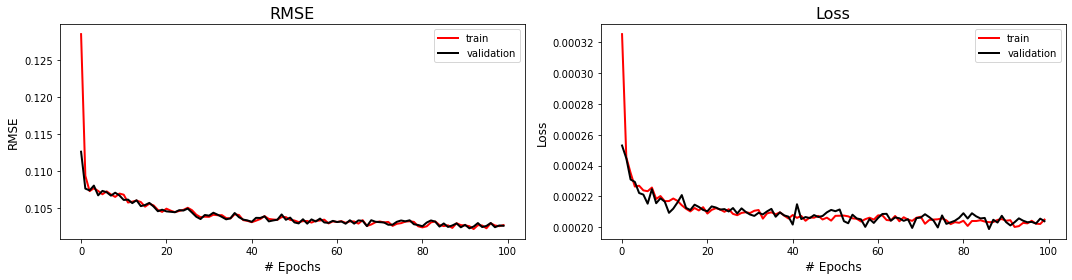

In [20]:
# Plotting trainnig metrics using pre-made function
fig,axs = plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

#### TO DO: DENOISE NEW NOISY DATASET

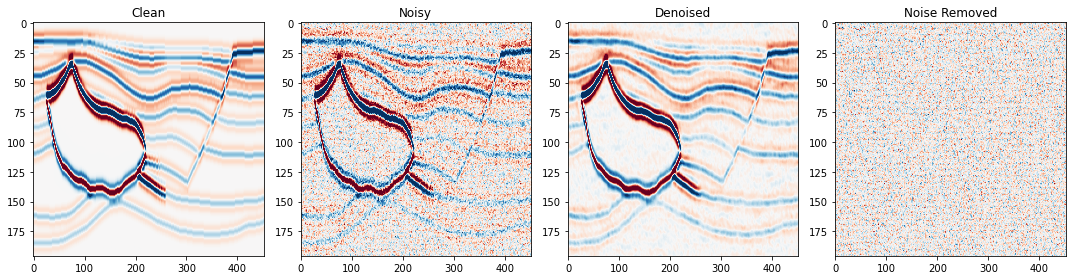

In [21]:
# Make a new noisy realisation so it's different from the training set but with roughly same level of noise
testdata, _ = add_whitegaussian_noise(d, sc=0.1)

# Convert dataset in tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = plot_synth_results(d, testdata, test_pred)